## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
%matplotlib inline
import re
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import tokenize
from io import BytesIO
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder


## Loading the Dataset

In [2]:
# Read the JSON file into a list of JSON objects with the specified encoding
with open("yelp_academic_dataset_review.json", "r", encoding="utf-8") as json_file:
    data = [json.loads(line) for line in json_file]

# Create a DataFrame from the list of JSON objects
df = pd.DataFrame(data)

In [3]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


## Exploratory Data Analysis

In [4]:
df.shape

(6990280, 9)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB


In [35]:
df.describe()

,stars,useful,funny,cool
count,6.990280e+06,6.990280e+06,6.990280e+06,6.990280e+06
mean,3.748584e+00,1.184609e+00,3.265596e-01,4.986175e-01
std,1.478705e+00,3.253767e+00,1.688729e+00,2.172460e+00
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,1.182000e+03,7.920000e+02,4.040000e+02


In [36]:
# Get the number of unique users and unique businesses
num_users = df["user_id"].nunique()
num_businesses = df["business_id"].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique businesses: {num_businesses}")

Number of unique users: 1987929
Number of unique businesses: 150346


### Looking at the distribution of the Star ratings given by the customers for the businesses

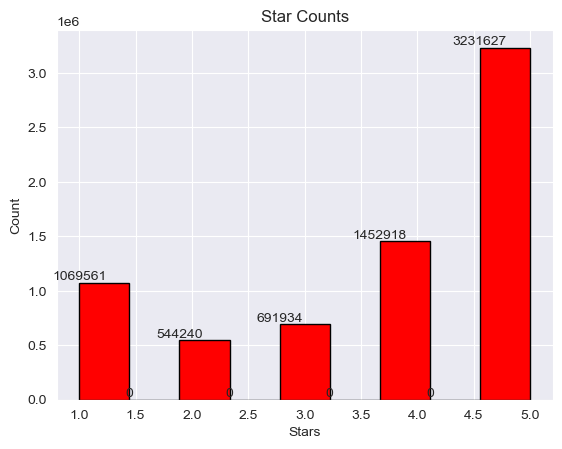

In [37]:
# Create a histogram (bar plot)
hist, bins, _ = plt.hist(df['stars'], bins=9, color='red', edgecolor='black')
plt.title("Star Counts")
plt.xlabel("Stars")
plt.ylabel("Count")

for i in range(len(hist)):
    plt.annotate(str(int(hist[i])), (bins[i], hist[i]), ha='center', va='bottom')
plt.show()


According to the results generated, we can see that there are high number of reviews that has the highest star ratings left by the users and also a significant amount of low star ratings that has been left by the users.

### Finding the Top 20 Users by the review count left by the users

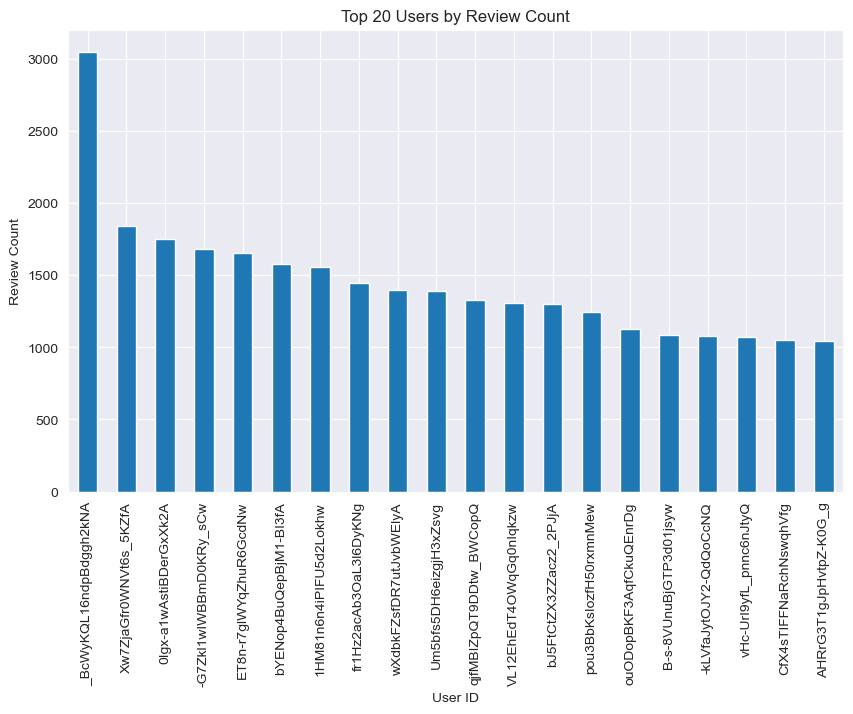

In [38]:
user_review_counts = df["user_id"].value_counts()

plt.figure(figsize=(10, 6))
user_review_counts[:20].plot(kind='bar')
plt.xlabel("User ID")
plt.ylabel("Review Count")
plt.title("Top 20 Users by Review Count")
plt.xticks(rotation=90)
plt.show()

### Finding the Top 50 Businesses according to the Average star rating

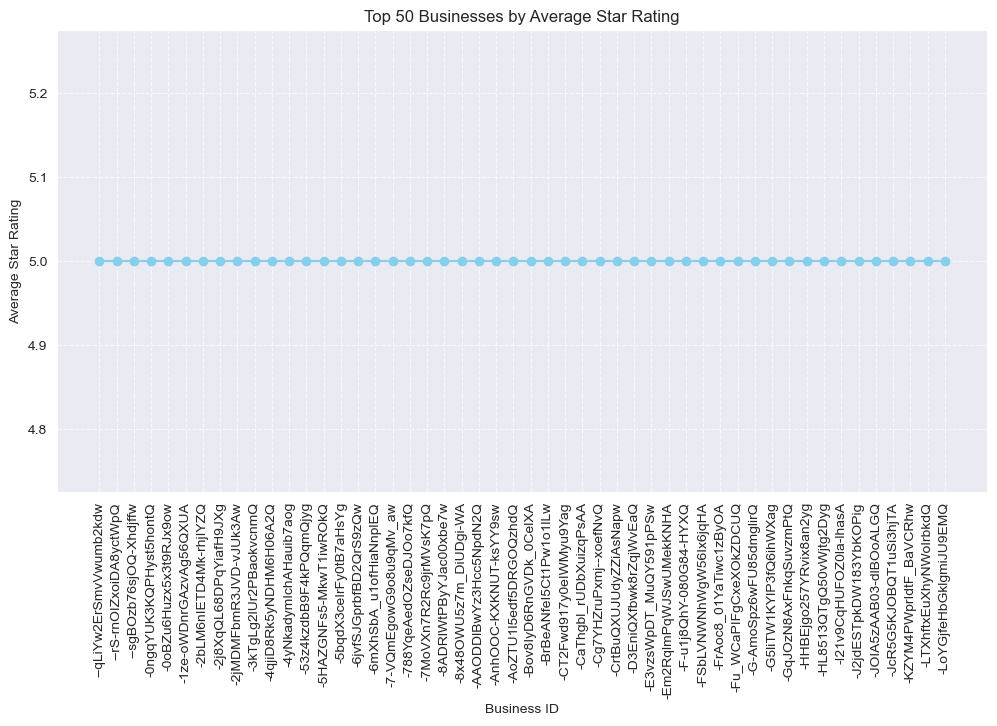

In [39]:
average_ratings = df.groupby("business_id")["stars"].mean()

top_50_businesses = average_ratings.nlargest(50)

plt.figure(figsize=(12, 6))
plt.plot(top_50_businesses.index, top_50_businesses.values, marker='o', color='skyblue', linestyle='-')
plt.xlabel("Business ID")
plt.ylabel("Average Star Rating")
plt.title("Top 50 Businesses by Average Star Rating")

plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

According to the result, we can see that since this dataset is quite large, after calculating the average star ratings received by all the businesses from the users, there are quite a few businesses that has received the highest average star rating; a 5.0

### Findings on the Businesses and their star Ratings

In [40]:
# Calculate the number of businesses with each average star rating
num_5_stars = (average_ratings == 5).sum()
num_4_stars = (average_ratings == 4).sum()
num_3_stars = (average_ratings == 3).sum()
num_2_stars = (average_ratings == 2).sum()
num_1_star = (average_ratings == 1).sum()

print(f"Number of businesses with an average rating of 5: {num_5_stars}")
print(f"Number of businesses with an average rating of 4: {num_4_stars}")
print(f"Number of businesses with an average rating of 3: {num_3_stars}")
print(f"Number of businesses with an average rating of 2: {num_2_stars}")
print(f"Number of businesses with an average rating of 1: {num_1_star}")

Number of businesses with an average rating of 5: 8995
Number of businesses with an average rating of 4: 3885
Number of businesses with an average rating of 3: 2794
Number of businesses with an average rating of 2: 1606
Number of businesses with an average rating of 1: 1165


### Finding the Top 50 Businesses according to the Number of Reviews

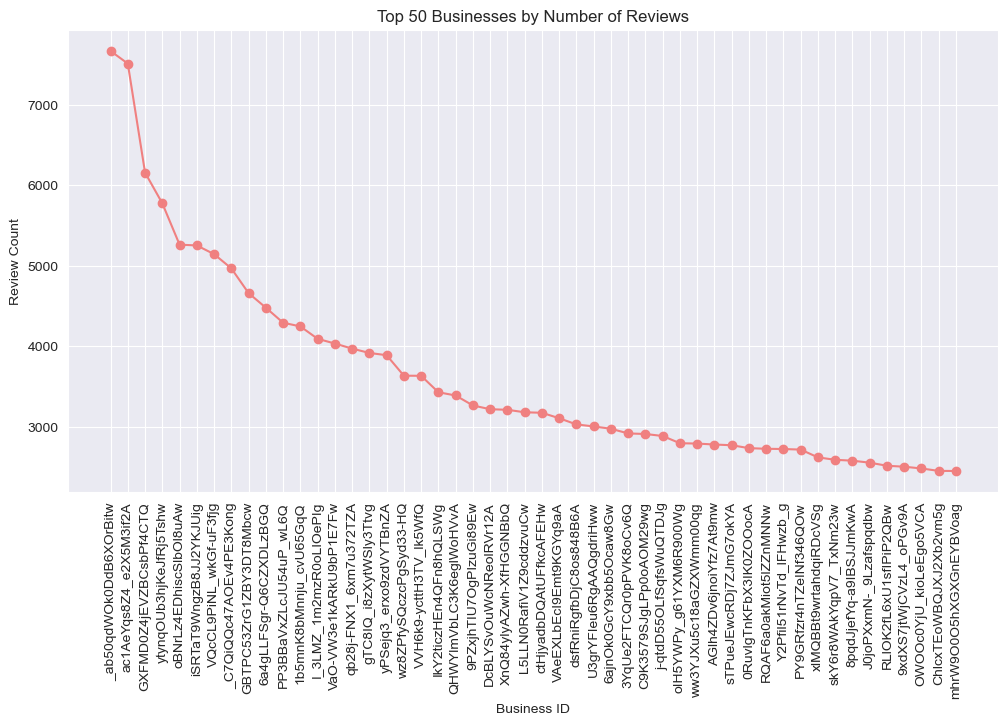

In [41]:
#Providing the number of reviews for each business
review_counts_per_business = df["business_id"].value_counts()

# Get the top 50 businesses by the number of reviews
top_50_businesses = review_counts_per_business.nlargest(50)
plt.figure(figsize=(12, 6))
plt.plot(top_50_businesses.index, top_50_businesses.values, marker='o', color='lightcoral', linestyle='-')
plt.xlabel("Business ID")
plt.ylabel("Review Count")
plt.title("Top 50 Businesses by Number of Reviews")
plt.xticks(rotation=90) 

plt.show()

### Time Analysis of the Yelp Reviews

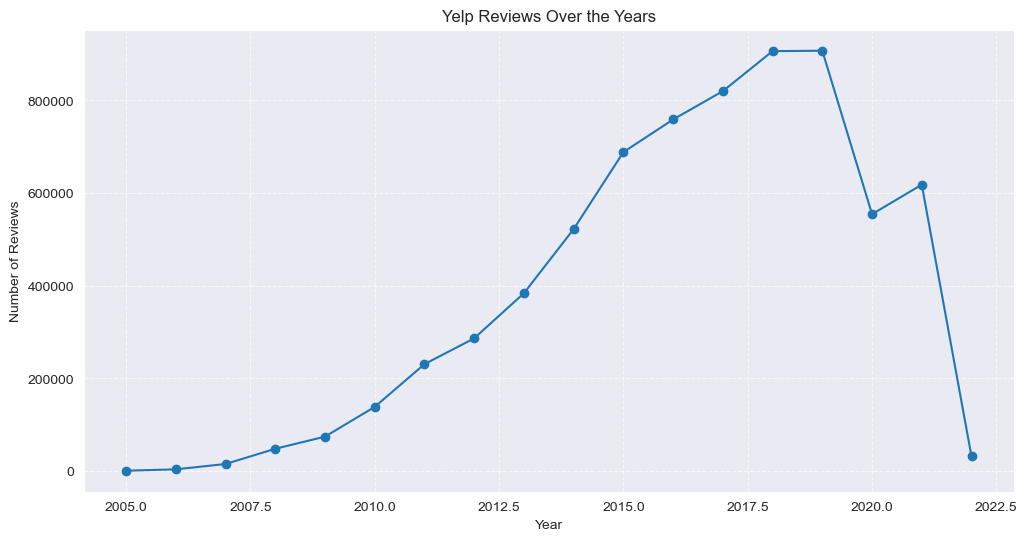

In [42]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year

reviews_per_year = df.groupby(df['year']).size()
plt.figure(figsize=(12, 6))
plt.plot(reviews_per_year.index, reviews_per_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Yelp Reviews Over the Years')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Correlation between the Review Types left by the users

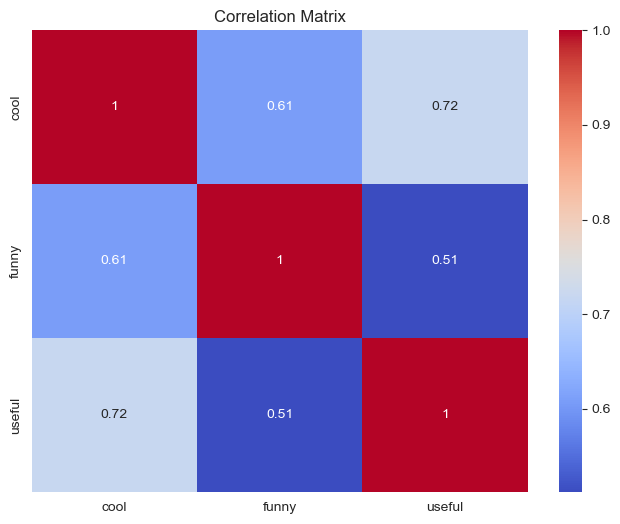

In [43]:
# Calculate and visualize the correlations between 'cool', 'funny', and 'useful'
correlation_matrix = df[['cool', 'funny', 'useful']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


According to the findings of the above code, we can see that
    - Reviews that was considered as a 'useful' review has a very high possibility of being a 'cool' review as well according to the other users
    - Reviews that was considered as a 'funny' review also has a good possibility pf being categorized as a 'cool' review according to the other users

### Displaying Top Reviewers with high ratings

In [44]:
# Identify top users with the most 'cool' ratings
top_cool_reviewers = df.groupby('user_id')['cool'].sum().nlargest(10)
print("Top Users with the Most 'Cool' Ratings:")
print(top_cool_reviewers)


Top Users with the Most 'Cool' Ratings:
user_id
-G7Zkl1wIWBBmD0KRy_sCw    26749
A4bsa7ykYRVCnb4h2vZALw    16997
lMY8NBPyzlPbbu-KBYfD9A    16175
tsMF0FcFcHZ8i28WzWtQXw    13780
fr1Hz2acAb3OaL3l6DyKNg    13145
vHc-UrI9yfL_pnnc6nJtyQ    12821
ET8n-r7glWYqZhuR6GcdNw    12585
wzUFZ3DaU7k9R2S54IMPfg    12124
6jjHo9Lilv3kTy87pm2ycw    10231
3QnoTcrxuafMCoTzW_AH7A     9658
Name: cool, dtype: int64


In [45]:
# Identify top users with the most 'funny' ratings
top_funny_reviewers = df.groupby('user_id')['funny'].sum().nlargest(10)
print("Top Users with the Most 'Funny' Ratings:")
print(top_funny_reviewers)


Top Users with the Most 'Funny' Ratings:
user_id
-G7Zkl1wIWBBmD0KRy_sCw    17774
A4bsa7ykYRVCnb4h2vZALw    11552
lMY8NBPyzlPbbu-KBYfD9A    10242
tsMF0FcFcHZ8i28WzWtQXw     8351
Kj-u8Yq1d3mLKitWsDAxpg     6827
qcf3A5mtPntTmmSfADo6tg     6759
3QnoTcrxuafMCoTzW_AH7A     5803
ET8n-r7glWYqZhuR6GcdNw     5631
wzUFZ3DaU7k9R2S54IMPfg     5581
JjXuiru1_ONzDkYVrHN0aw     5320
Name: funny, dtype: int64


In [46]:
# Identify top users with the most 'useful' ratings
top_useful_reviewers = df.groupby('user_id')['useful'].sum().nlargest(10)
print("Top Users with the Most 'Useful' Ratings:")
print(top_useful_reviewers)


Top Users with the Most 'Useful' Ratings:
user_id
-G7Zkl1wIWBBmD0KRy_sCw    34694
ET8n-r7glWYqZhuR6GcdNw    19474
vHc-UrI9yfL_pnnc6nJtyQ    17851
A4bsa7ykYRVCnb4h2vZALw    17702
lMY8NBPyzlPbbu-KBYfD9A    17358
fr1Hz2acAb3OaL3l6DyKNg    15356
tsMF0FcFcHZ8i28WzWtQXw    15112
wzUFZ3DaU7k9R2S54IMPfg    13400
Xw7ZjaGfr0WNVt6s_5KZfA    12011
bYENop4BuQepBjM1-BI3fA    11680
Name: useful, dtype: int64


### Top 'Useful' Reviews

In [ ]:
top_N = 10 

# Sort the dataset by the "useful" column in descending order
top_useful_reviews = df.sort_values(by='useful', ascending=False).head(top_N)

# Display the top N reviews and their associated text
print("Top {} Reviews with the Most 'Useful' Counts:".format(top_N))
for index, row in top_useful_reviews.iterrows():
    print("Review ID: ", row['review_id'])
    print("Useful Count: ", row['useful'])
    print("Review Text: ", row['text'])
    print("\n")


### For More Deep Analysis - Creating Features

Here, we created the "Customer Experience" column, where we categorise the Stars provided to various businesses as GOOD, BAD, or NEUTRAL.

In addition, we created a new feature called "Text Length", which shows the length of the reviews. This functionality will help us understand consumer behaviour and experiences.

In [ ]:
# Create a function to categorize star ratings
def categorize_customer_exp(rating):
    if rating in (1, 2):
        return 'BAD'
    elif rating == 3:
        return 'NEUTRAL'
    else:
        return 'GOOD'

df['Customer EXP'] = df['stars'].apply(categorize_customer_exp)

customer_exp_counts = df['Customer EXP'].value_counts()

df['Text length'] = df['text'].apply(lambda x: len(x.split()))
df.head()

### Customer Experience vs Text Length of the Reviews

In [ ]:
# Create separate data frames for each "Customer EXP" category
bad_reviews = df[df['Customer EXP'] == 'BAD']
neutral_reviews = df[df['Customer EXP'] == 'NEUTRAL']
good_reviews = df[df['Customer EXP'] == 'GOOD']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for i, (category, color) in enumerate(zip(['BAD', 'NEUTRAL', 'GOOD'], ['red', 'green', 'blue'])):
    ax = axes[i]
    ax.hist(df[df['Customer EXP'] == category]['Text length'], bins=20, color=color, alpha=0.7)
    ax.set_title(f'{category} Customer EXP')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()
mean_text_length = df.groupby('Customer EXP')['Text length'].mean()
print("Mean Text Length by Customer EXP:")
print(mean_text_length)


The density distributions and histograms of text lengths for reviews designated as GOOD, BAD, and NEUTRAL are shown in the graph above. People who rate a business as BAD or NEUTRAL have roughly 150 words in their evaluations, but people who are supposed to assess the business as GOOD have approximately 100 words in their reviews.


### Average Text Length Vs Star Rating

In [ ]:
average_text_length = df.groupby('stars')['Text length'].mean()

plt.figure(figsize=(10, 7))
plt.bar(average_text_length.index, average_text_length.values, color='skyblue')
plt.xlabel('Star Rating')
plt.ylabel('Average Text Length')
plt.title('Average Text Length by Star Rating')
plt.xticks(average_text_length.index)
plt.show()


According to the above graph as well, we can see that customers who have given a high star rating has a low average text length(80-100) in their reviews while customers who have given a low and neutral star rating has a high average text length(120-130) in their reviews.

### Distribution of Customer Experience

In [ ]:
customer_exp_counts = df['Customer EXP'].value_counts()

plt.figure(figsize=(7, 5))
plt.bar(customer_exp_counts.index, customer_exp_counts.values, color='orange')
plt.xlabel('Customer EXP')
plt.ylabel('Count')
plt.title('Distribution of Customer EXP')
plt.show()


In the bar chart depicting the distribution of customer experiences, we observe that there is a substantial number of reviews categorized as 'GOOD,' indicating a positive customer experience. Conversely, there are relatively few reviews categorized as 'NEUTRAL,' but a significant amount of 'BAD' reviews more than the 'NEUTRAL' reviews. This suggests that the majority of reviews in the dataset reflect positive customer experiences, with a smaller portion expressing neutral or negative sentiments.

### Correlation between the Review Types left by the users after adding the Text Length

In [ ]:
#When we categorise the data set by STARS, we can find the correlation between COOL, USEFUL, FUNNY, and TEXT_LENGTH characteristics after adding the TEXT_LENGTH feature

# Select the columns of interest for correlation
columns_of_interest = ['stars', 'cool', 'funny', 'useful', 'Text length']

# Calculate the correlation between the selected columns by 'Customer EXP'
correlation_matrix = df.groupby('Customer EXP')[columns_of_interest].mean().corr()

print("Correlation Matrix:")
print(correlation_matrix)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)
ax.set_xticks(np.arange(-0.5, len(correlation_matrix.columns)-0.5, 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(correlation_matrix.index)-0.5, 1), minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
plt.title('Correlation Heatmap for Mean Values by Customer EXP')
plt.show()

In our analysis of the dataset, we observed notable correlations among various characteristics when categorizing by star ratings. Specifically, we found:

1. There is a strong positive correlation between the 'funny' and 'Text length' characteristics. This suggests that, in general, longer reviews tend to contain more humor or amusing content.

2. We also identified a high positive correlation between 'cool' and 'funny.' It appears that reviews with a higher number of 'funny' interactions are often considered 'cool' by other users.

3. Additionally, we noted a significant positive correlation between 'cool' and 'Text length.' Longer reviews are often associated with a higher number of 'cool' interactions.

## Preprocessing of the Dataset ('text' column cleaning)

In [5]:
# Creating a new df with the required columns
columns_required = ['review_id','stars','text']
df_rc = df[columns_required ]
df_rc.head()

,review_id,stars,text
0,KU_O5udG6zpxOg-VcAEodg,3.0,"If you decide to eat here, just be aware it is..."
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...
2,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...


## Getting a Subset of the Dataset for easier Handling

In [6]:
df_rc = df_rc.head(10000)
print('Data length: ', len(df_rc))

Data length:  10000


In [7]:
# Checking duplicate reviews
duplicates = df_rc.duplicated()

if duplicates.any():
    print("There are duplicate rows in the Data Frame.")
else:
    print("No duplicate rows found in the Data Frame.")


No duplicate rows found in the Data Frame.


In [8]:
# Checking null values
print('Number of missing values: ', df_rc.isnull().values.sum())
print('Data length: ', len(df_rc))

Number of missing values:  0
Data length:  10000


#### Analysing what the texts contain before preprocessing to identify what are the preprocessing techniques to be followed for the dataset

In [9]:
df_rc.text[0]

"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."

In [10]:
df_rc.text[1000]

"Pricey ( a ham and cheese croissant was $5.50)  as with anywhere in Santa Barbra but very delicious. Cute space ( a bit hard to find ). The green eggs and ham  breakfast biscuit is to die for.  ($10 I think) The Santa Barbra tri tip sandwich was excellent! Cold brew coffee was good. Lots of good choices in the grab and go section, and our salami and pesto sammy was also great. I'd go back!"

In [11]:
#index resetting
df_rc.reset_index(drop=True, inplace=True)
df_rc.loc[:, "index"] = df_rc.index.values
df_rc.head()

,review_id,stars,text,index
0,KU_O5udG6zpxOg-VcAEodg,3.0,"If you decide to eat here, just be aware it is...",0
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1
2,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,2
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4


In [12]:
#Removing 3 stars since they can have both negative and positive feelings

#Checking for the 3-star entries count before removing 3 stars
count_3_stars = len(df_rc[df_rc["stars"] == 3])
print("Count of 3-star entries before:", count_3_stars)

Count of 3-star entries before: 1139


In [13]:
#Removing 3-star entries
df_rc = df_rc[(df_rc["stars"]!=3)]

In [14]:
#Checking for the 3-star entries count after removing 3 stars
count_3_stars = len(df_rc[df_rc["stars"] == 3])
print("Count of star entries after:", count_3_stars)

Count of star entries after: 0


In [15]:
df_rc.head()

,review_id,stars,text,index
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6


In [16]:
#Coverting to lowercase
df_rc.loc[:, 'clean_text'] = df_rc['text'].str.lower()

In [17]:
df_rc.head()

,review_id,stars,text,index,clean_text
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,i've taken a lot of spin classes over the year...
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,"wow! yummy, different, delicious. our favo..."
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior and owner (?) gave us tour of up...
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,i am a long term frequent customer of this est...
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved this tour! i grabbed a groupon and the p...


In [18]:
# removing email addresses since they do not mean anything for sentiment analysis
df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: re.sub(r'\S+@\S+', '', x))

In [19]:
df_rc.head()

,review_id,stars,text,index,clean_text
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,i've taken a lot of spin classes over the year...
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,"wow! yummy, different, delicious. our favo..."
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior and owner (?) gave us tour of up...
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,i am a long term frequent customer of this est...
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved this tour! i grabbed a groupon and the p...


In [20]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [21]:
custom_stop_words = set(stopwords.words('english')) - {'not', "don't", "no", "don", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "migh", "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"}
print(custom_stop_words)

{'more', 'they', "should've", 'during', 'ourselves', 'whom', 'because', 'some', 'nor', 'is', 'most', 'yourself', 'were', 'as', 'while', 'to', 'have', 'now', 'after', 'all', 'below', 'hers', 'other', 'for', 'how', 'and', 'your', 'with', 'd', 'ours', "it's", 'up', 'will', 'doing', 'of', 'her', "you're", 'his', 'it', 'was', 'a', 'or', 'our', 'who', 'o', 've', 'once', 'should', 'by', 'can', 'does', 'further', 'too', 'y', 'an', 'being', "she's", 'my', 'been', 'in', 'about', 'him', 'this', 'only', 'so', 'myself', 'themselves', 'here', 'the', 'very', 'yours', 'll', 're', 'itself', 'she', 'into', 'which', 'each', 'had', 'at', 'do', 'between', 'same', 'from', "you'll", 'its', 'having', 'are', 'both', 'ma', 'when', 'down', 'than', 'those', 'against', 'any', 'we', 'such', 'that', 's', 'before', 'did', 'them', "that'll", "you've", 't', 'there', 'few', 'off', 'again', 'then', 'what', 'yourselves', 'has', 'on', 'own', 'until', 'under', "you'd", 'himself', 'these', 'just', 'where', 'be', 'if', 'me', 

In [22]:
# removing stop words
custom_stop_words = set(stopwords.words('english')) - {'not', "don't", "no", "don", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "migh", "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"}
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in custom_stop_words])

df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: remove_stopwords(x))

In [23]:
df_rc.head()

,review_id,stars,text,index,clean_text
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,"i've taken lot spin classes years, nothing com..."
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,"wow! yummy, different, delicious. favorite lam..."
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner (?) gave us tour upcoming ...
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment. wen...
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour! grabbed groupon price great. perfe...


In [24]:
# Removing punctuation marks
def remove_punctuations(text):
    punctuations = string.punctuation
    return text.translate(str.maketrans('', '', punctuations))

df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: remove_punctuations(x))

In [25]:
df_rc.head()

,review_id,stars,text,index,clean_text
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,ive taken lot spin classes years nothing compa...
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,wow yummy different delicious favorite lamb cu...
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner gave us tour upcoming pat...
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment went...
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour grabbed groupon price great perfect...


In [26]:
# Removing special characters and emojis
def removing_special_characters(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text
df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: removing_special_characters(x))

In [27]:
df_rc.head()

,review_id,stars,text,index,clean_text
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,ive taken lot spin classes years nothing compa...
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,wow yummy different delicious favorite lamb cu...
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner gave us tour upcoming pati...
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment went...
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour grabbed groupon price great perfect...


In [28]:
# Removing numeric characters
def remove_words_with_numerical_characters(text):
    if text and not pd.isna(text):
        words = text.split()
        filtered_words = [w for w in words if not re.findall(r'\d+', w)]
        return ' '.join(filtered_words)

df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: remove_words_with_numerical_characters(x))

In [29]:
df_rc.head()

,review_id,stars,text,index,clean_text
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,ive taken lot spin classes years nothing compa...
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,wow yummy different delicious favorite lamb cu...
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner gave us tour upcoming pati...
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment went...
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour grabbed groupon price great perfect...


### Tokenization

In [30]:
df_rc['tokens'] = df_rc['clean_text'].apply(lambda text: [token.string for token in tokenize.tokenize(BytesIO(text.encode()).readline) if token.string.isalnum()] if text is not None else [])

# Remove the 'utf-8' token from each list of tokens
df_rc['tokens'] = df_rc['tokens'].apply(lambda tokens: [token for token in tokens if token !='utf-8'])

In [31]:
df_rc.head()

,review_id,stars,text,index,clean_text,tokens
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,ive taken lot spin classes years nothing compa...,"[ive, taken, lot, spin, classes, years, nothin..."
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l..."
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner gave us tour upcoming pati...,"[cute, interior, owner, gave, us, tour, upcomi..."
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment went...,"[long, term, frequent, customer, establishment..."
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour grabbed groupon price great perfect...,"[loved, tour, grabbed, groupon, price, great, ..."


### Lemmatization

In [33]:
lemmatizer = WordNetLemmatizer()

# Lemmatize the tokens in the 'tokens' column
df_rc['lemmas'] = df_rc['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [34]:
df_rc.head()

,review_id,stars,text,index,clean_text,tokens,lemmas
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,ive taken lot spin classes years nothing compa...,"[ive, taken, lot, spin, classes, years, nothin...","[ive, taken, lot, spin, class, year, nothing, ..."
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l...","[wow, yummy, different, delicious, favorite, l..."
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner gave us tour upcoming pati...,"[cute, interior, owner, gave, us, tour, upcomi...","[cute, interior, owner, gave, u, tour, upcomin..."
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment went...,"[long, term, frequent, customer, establishment...","[long, term, frequent, customer, establishment..."
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour grabbed groupon price great perfect...,"[loved, tour, grabbed, groupon, price, great, ...","[loved, tour, grabbed, groupon, price, great, ..."


In [35]:
# Detokenize and create a new column 'preprocessed_text'
df_rc['preprocessed_text'] = df_rc['lemmas'].apply(lambda lemmas: ' '.join(lemmas))

In [37]:
df_rc.head()

,review_id,stars,text,index,clean_text,tokens,lemmas,preprocessed_text
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,ive taken lot spin classes years nothing compa...,"[ive, taken, lot, spin, classes, years, nothin...","[ive, taken, lot, spin, class, year, nothing, ...",ive taken lot spin class year nothing compare ...
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l...","[wow, yummy, different, delicious, favorite, l...",wow yummy different delicious favorite lamb cu...
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner gave us tour upcoming pati...,"[cute, interior, owner, gave, us, tour, upcomi...","[cute, interior, owner, gave, u, tour, upcomin...",cute interior owner gave u tour upcoming patio...
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment went...,"[long, term, frequent, customer, establishment...","[long, term, frequent, customer, establishment...",long term frequent customer establishment went...
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour grabbed groupon price great perfect...,"[loved, tour, grabbed, groupon, price, great, ...","[loved, tour, grabbed, groupon, price, great, ...",loved tour grabbed groupon price great perfect...


In [38]:
df_rc = df_rc[df_rc['preprocessed_text'] != '']

### Labelling the dataset

In [40]:
def map_star_to_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 'Negative'
    elif star_rating in [4, 5]:
        return 'Positive'

df_rc['class'] = df_rc['stars'].apply(map_star_to_sentiment)

In [41]:
df_rc.head()

,review_id,stars,text,index,clean_text,tokens,lemmas,preprocessed_text,class
1,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,ive taken lot spin classes years nothing compa...,"[ive, taken, lot, spin, classes, years, nothin...","[ive, taken, lot, spin, class, year, nothing, ...",ive taken lot spin class year nothing compare ...,Positive
3,AqPFMleE6RsU23_auESxiA,5.0,"Wow! Yummy, different, delicious. Our favo...",3,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l...","[wow, yummy, different, delicious, favorite, l...",wow yummy different delicious favorite lamb cu...,Positive
4,Sx8TMOWLNuJBWer-0pcmoA,4.0,Cute interior and owner (?) gave us tour of up...,4,cute interior owner gave us tour upcoming pati...,"[cute, interior, owner, gave, us, tour, upcomi...","[cute, interior, owner, gave, u, tour, upcomin...",cute interior owner gave u tour upcoming patio...,Positive
5,JrIxlS1TzJ-iCu79ul40cQ,1.0,I am a long term frequent customer of this est...,5,long term frequent customer establishment went...,"[long, term, frequent, customer, establishment...","[long, term, frequent, customer, establishment...",long term frequent customer establishment went...,Negative
6,6AxgBCNX_PNTOxmbRSwcKQ,5.0,Loved this tour! I grabbed a groupon and the p...,6,loved tour grabbed groupon price great perfect...,"[loved, tour, grabbed, groupon, price, great, ...","[loved, tour, grabbed, groupon, price, great, ...",loved tour grabbed groupon price great perfect...,Positive


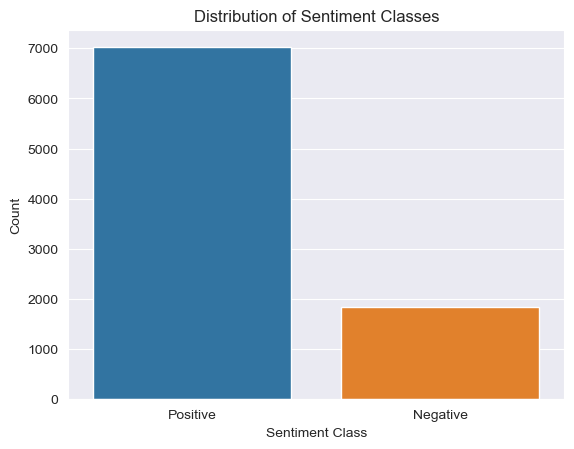

In [42]:
### Checking the number of positive and negative 
sns.countplot(x='class', data=df_rc)
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes')
plt.show()

### Generating the Word Cloud visualization for positive and negative reviews

In [43]:
def generate_wordcloud(text_list, title):
    text = ' '.join(text_list)
    wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

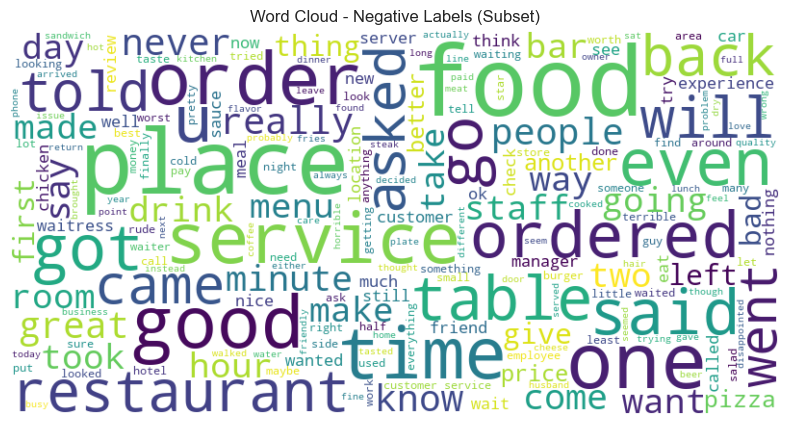

In [44]:
negative_subset = df_rc.loc[df_rc['class'] == 'Negative', 'text'].head(10000)
generate_wordcloud(negative_subset, 'Word Cloud - Negative Labels (Subset)')

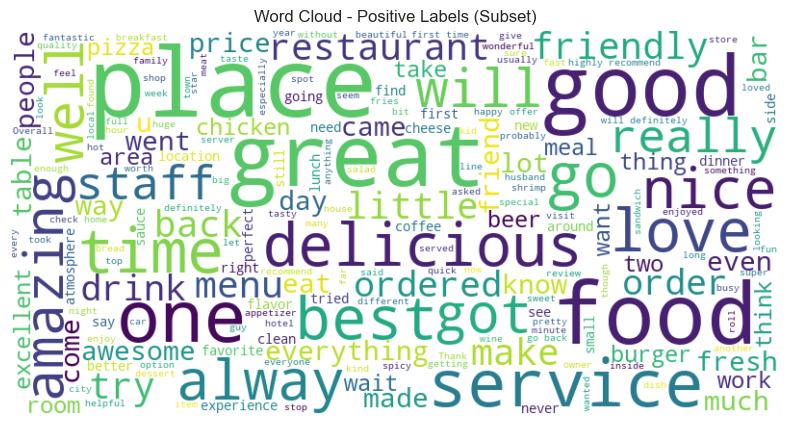

In [45]:
positive_subset = df_rc.loc[df_rc['class'] == 'Positive', 'text'].head(10000)
generate_wordcloud(positive_subset, 'Word Cloud - Positive Labels (Subset)')

In [46]:
# Drop the target column to create features (X)
X = df_rc['preprocessed_text']

# Use the target column as labels (y)
y = df_rc['class']

## Converting the target variables to numeric form

In [47]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Convert y to integer

In [48]:
y = y.astype(int)

### Saving the X and y in csv files separately

In [50]:
X.to_csv('X.csv')
np.savetxt('y.csv', y, delimiter=',')